<a href="https://colab.research.google.com/github/Formula-Electric-Berkeley/FEBSim/blob/main/DRB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

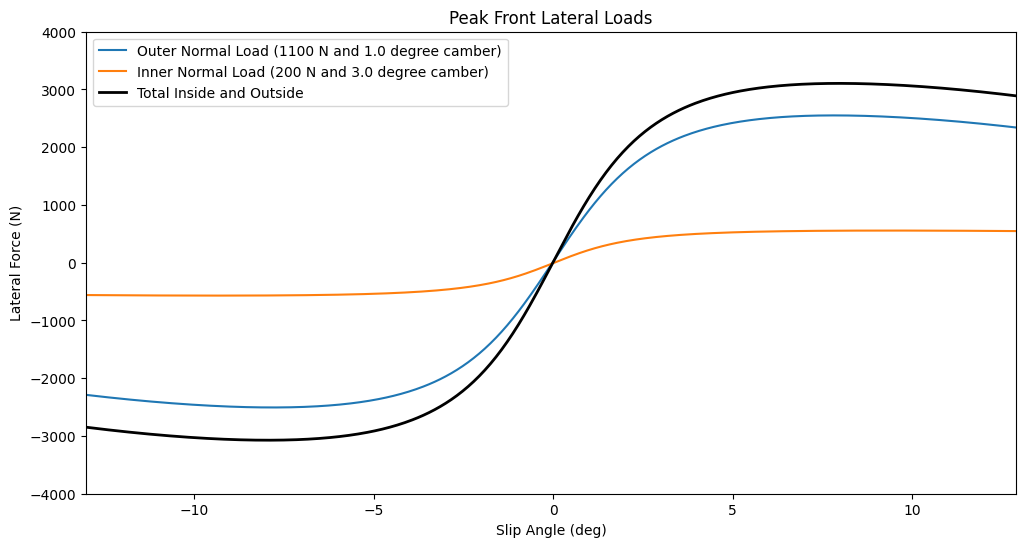

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit

# Define the simplified Pacejka model function
def pacejka_model(alpha, B, C, D, E, F):
    return D * np.sin(C * np.arctan(B * alpha - E * (B * alpha - np.arctan(B * alpha))) + F)

# Load and clean the data
data_path = r'B1320run52.csv'
data = pd.read_csv(data_path)
data = data.drop(data.index[0])
data['FY'] = pd.to_numeric(data['FY'], errors='coerce') * -1
data['SA'] = pd.to_numeric(data['SA'], errors='coerce')
data['FZ'] = pd.to_numeric(data['FZ'], errors='coerce')
data['IA'] = pd.to_numeric(data['IA'], errors='coerce')
data['V'] = pd.to_numeric(data['V'], errors='coerce')
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(subset=['FY', 'SA', 'FZ', 'IA', 'V'], inplace=True)

# Define bins with specific ranges
bins = [
    {'fz_range': (-1200, -1000), 'ia_range': (0.9, 1.1), 'v_range': (0, 42)},
    {'fz_range': (-300, -100), 'ia_range': (2.9, 3.1), 'v_range': (0, 42)}
]
model_params = []

# Fit model for each bin
for bin_info in bins:
    filtered_data = data[
        (data['FZ'] >= bin_info['fz_range'][0]) & (data['FZ'] <= bin_info['fz_range'][1]) &
        (data['IA'] >= bin_info['ia_range'][0]) & (data['IA'] <= bin_info['ia_range'][1]) &
        (data['V'] >= bin_info['v_range'][0]) & (data['V'] <= bin_info['v_range'][1])
        ]
    x_data = filtered_data['SA']
    y_data = filtered_data['FY']
    if not x_data.empty and not y_data.empty:
        initial_guess = [0.5, 1.2, max(y_data), 1, 0]
        optimal_parameters, _ = curve_fit(pacejka_model, x_data, y_data, p0=initial_guess, maxfev=15000)
        model_params.append((bin_info, optimal_parameters))

# Prepare to plot
# Prepare to plot
# Custom labels for the curves
custom_labels = {
    'bin1': 'Outer Normal Load (1100 N and 1.0 degree camber)',
    'bin2': 'Inner Normal Load (200 N and 3.0 degree camber)',
}

# Prepare to plot
fig, ax = plt.subplots(figsize=(12, 6))

x_model = np.linspace(min(data['SA']), max(data['SA']), 500)


# Compute and plot individual curves and add to total curve
y_total_model = np.zeros_like(x_model)

# Assuming x_model is already defined in your code

for index, (bin_info, params) in enumerate(model_params):
    y_model = pacejka_model(x_model, *params)
    y_total_model += y_model  # Sum up contributions
    label_key = 'bin1' if index == 0 else 'bin2'  # Assuming two bins
    ax.plot(x_model, y_model, label=custom_labels[label_key])

# Plot the total curve
ax.plot(x_model, y_total_model, color='black', linestyle='-', linewidth=2, label='Total Inside and Outside')

# Set axis titles and limits
ax.set_title('Peak Front Lateral Loads')
ax.set_xlabel('Slip Angle (deg)')
ax.set_ylabel('Lateral Force (N)')
ax.set_xlim(min(x_model), max(x_model))
ax.set_ylim(-4000, 4000)

# Display the legend
ax.legend()

# Show the plot
plt.show()




In [ ]:
import numpy as np

# Compute the index of the maximum y value in the combined curve
max_index = np.argmax(y_total_model)

# Retrieve the corresponding x value (slip angle) from x_model
max_x = x_model[max_index]

# Retrieve the maximum y value from y_total_model
max_y = y_total_model[max_index]

# Print the maximum ordered pair (x, y)
print("Maximum ordered pair (Slip Angle, Lateral Force):", (max_x, max_y))


Maximum ordered pair (Slip Angle, Lateral Force): (7.9583767535070145, 3105.361746434705)


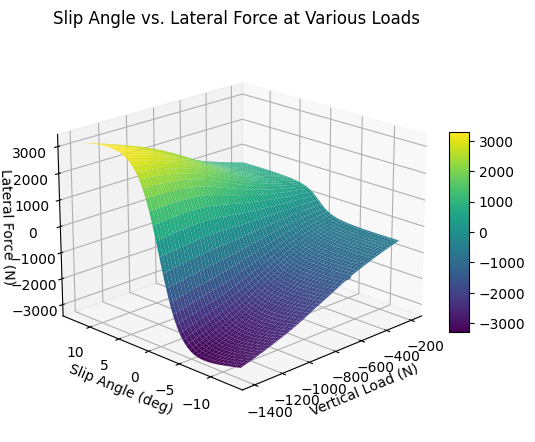

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D

# Define the simplified Pacejka model function
def pacejka_model(alpha, B, C, D, E, F):
    return D * np.sin(C * np.arctan(B * alpha - E * (B * alpha - np.arctan(B * alpha))) + F)

# Load the data
data_path = r'B1320run52.csv'
data = pd.read_csv(data_path, skiprows=0)
data = data.drop(data.index[0])
data['FY'] = pd.to_numeric(data['FY'], errors='coerce') * -1
data['SA'] = pd.to_numeric(data['SA'], errors='coerce')
data['FZ'] = pd.to_numeric(data['FZ'], errors='coerce')

# Define load ranges and prepare data
load_ranges = [(-1600, -1200), (-1200, -800), (-800, -400), (-400, 0)]
fitted_results = []

# Collect fitted results
for lower_bound, upper_bound in load_ranges:
    filtered_data = data[(data['FZ'] >= lower_bound) & (data['FZ'] <= upper_bound)]
    if not filtered_data.empty:
        x_data = filtered_data['SA']
        y_data = filtered_data['FY']
        try:
            popt, _ = curve_fit(pacejka_model, x_data, y_data, p0=[0.5, 1.2, max(y_data), 1, 0], maxfev=15000)
            fitted_results.extend([(np.mean([lower_bound, upper_bound]), sa, pacejka_model(sa, *popt)) for sa in np.linspace(x_data.min(), x_data.max(), 50)])
        except:
            continue

# Convert results to DataFrame
df_results = pd.DataFrame(fitted_results, columns=['FZ', 'SA', 'FY'])




# Assume data preparation and grid setup as before

# Create a figure with adjusted dimensions
fig = plt.figure(figsize=(14, 10))  # Adjusted for wider and taller space
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(grid_x, grid_y, grid_z, cmap='viridis')

# Labeling axes and setting title
ax.set_xlabel('Vertical Load (N)', labelpad=1)
ax.set_ylabel('Slip Angle (deg)', labelpad=1)
ax.set_zlabel('Lateral Force (N)', labelpad=1)
ax.set_title('Slip Angle vs. Lateral Force at Various Loads')

# Adjusting the subplot to better accommodate the color bar and labels
plt.subplots_adjust(left=0.1, right=0.95, top=0.5, bottom=0.1)  # Increased left and adjusted right

# Position and size the color bar
cbar = fig.colorbar(surf, shrink=0.5, aspect=10, pad=0.01)
cbar.set_label('', labelpad=5)

# Viewing angles for better visibility of labels and surface
ax.view_init(elev=20, azim=-135)

plt.show()


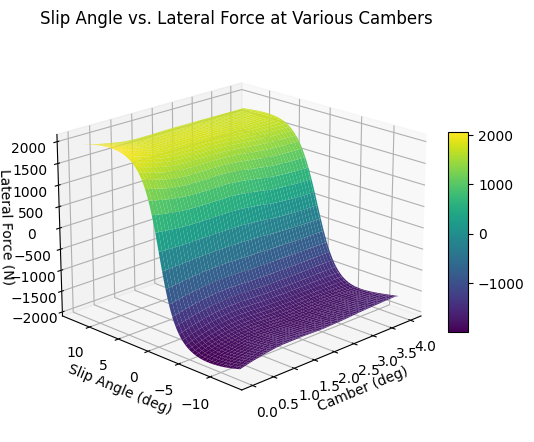

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D

# Define the simplified Pacejka model function
def pacejka_model(alpha, B, C, D, E, F):
    return D * np.sin(C * np.arctan(B * alpha - E * (B * alpha - np.arctan(B * alpha))) + F)

# Load the data
data_path = 'B1320run52.csv'
data = pd.read_csv(data_path)
data = data.drop(data.index[0])
data['FY'] = pd.to_numeric(data['FY'], errors='coerce') * -1
data['SA'] = pd.to_numeric(data['SA'], errors='coerce')
data['FZ'] = pd.to_numeric(data['FZ'], errors='coerce')
data['IA'] = pd.to_numeric(data['IA'], errors='coerce')

# Define camber ranges and prepare data
camber_ranges = [(0.02, 0.05), (0.9, 1.1), (1.9, 2.1), (2.9, 3.1), (3.9, 4.1)]
fitted_results = []

# Collect fitted results for each camber range
for lower_bound, upper_bound in camber_ranges:
    filtered_data = data[(data['IA'] >= lower_bound) & (data['IA'] <= upper_bound)]
    if not filtered_data.empty:
        x_data = filtered_data['SA']
        y_data = filtered_data['FY']
        try:
            popt, _ = curve_fit(pacejka_model, x_data, y_data, p0=[0.5, 1.2, max(y_data), 1, 0], maxfev=15000)
            fitted_results.extend([(np.mean([lower_bound, upper_bound]), sa, pacejka_model(sa, *popt)) for sa in np.linspace(x_data.min(), x_data.max(), 50)])
        except Exception as e:
            print(e)
            continue

# Convert results to DataFrame
df_results = pd.DataFrame(fitted_results, columns=['IA', 'SA', 'FY'])

# Create grid for interpolation
grid_x, grid_y = np.meshgrid(
    np.linspace(df_results['IA'].min(), df_results['IA'].max(), 100),
    np.linspace(df_results['SA'].min(), df_results['SA'].max(), 100)
)

# Interpolate results
grid_z = griddata((df_results['IA'], df_results['SA']), df_results['FY'], (grid_x, grid_y), method='cubic')

# Plotting the surface
fig = plt.figure(figsize=(14, 10))  # Adjusted for wider and taller space
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(grid_x, grid_y, grid_z, cmap='viridis')

# Labeling axes and setting title
ax.set_xlabel('Camber (deg)', labelpad=1)
ax.set_ylabel('Slip Angle (deg)', labelpad=1)
ax.set_zlabel('Lateral Force (N)', labelpad=1)
ax.set_title('Slip Angle vs. Lateral Force at Various Cambers')

# Adjusting the subplot to better accommodate the color bar and labels
plt.subplots_adjust(left=0.1, right=0.95, top=0.5, bottom=0.1)  # Increased left and adjusted right

# Position and size the color bar
cbar = fig.colorbar(surf, shrink=0.5, aspect=10, pad=0.01)
cbar.set_label('', labelpad=5)

# Viewing angles for better visibility of labels and surface
ax.view_init(elev=20, azim=-135)

plt.show()

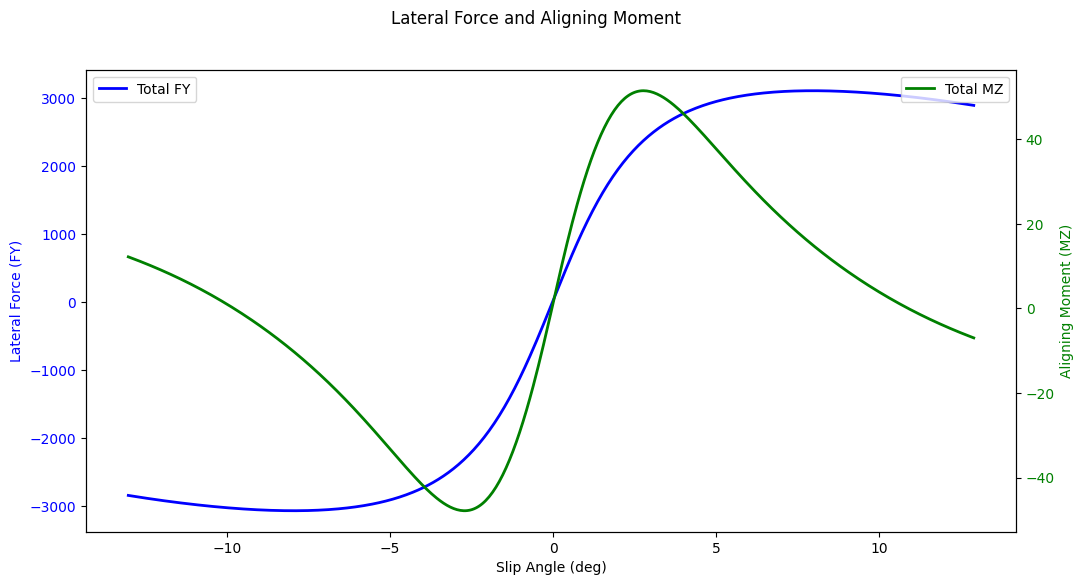

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

# Define the simplified Pacejka model function
def pacejka_model(alpha, B, C, D, E, F):
    return D * np.sin(C * np.arctan(B * alpha - E * (B * alpha - np.arctan(B * alpha))) + F)

# Load and clean the data
data_path = 'B1320run52.csv'
data = pd.read_csv(data_path)
data['FY'] = pd.to_numeric(data['FY'], errors='coerce') * -1
data['SA'] = pd.to_numeric(data['SA'], errors='coerce')
data['FZ'] = pd.to_numeric(data['FZ'], errors='coerce')
data['IA'] = pd.to_numeric(data['IA'], errors='coerce')
data['V'] = pd.to_numeric(data['V'], errors='coerce')
data['MZ'] = pd.to_numeric(data['MZ'], errors='coerce') * -1  # Assuming MZ is also a column
data.dropna(subset=['FY', 'SA', 'FZ', 'IA', 'V', 'MZ'], inplace=True)

# Define bins with specific ranges
bins = [
    {'fz_range': (-1200, -1000), 'ia_range': (0.9, 1.1), 'v_range': (0, 42)},
    {'fz_range': (-300, -100), 'ia_range': (2.9, 3.1), 'v_range': (0, 42)}
]
model_params_fy = []
model_params_mz = []

# Fit model for each bin for FY and MZ
x_model = np.linspace(min(data['SA']), max(data['SA']), 500)
y_total_model = np.zeros_like(x_model)
z_total_model = np.zeros_like(x_model)

for bin_info in bins:
    filtered_data = data[
        (data['FZ'] >= bin_info['fz_range'][0]) & (data['FZ'] <= bin_info['fz_range'][1]) &
        (data['IA'] >= bin_info['ia_range'][0]) & (data['IA'] <= bin_info['ia_range'][1]) &
        (data['V'] >= bin_info['v_range'][0]) & (data['V'] <= bin_info['v_range'][1])
        ]
    x_data = filtered_data['SA']
    fy_data = filtered_data['FY']
    mz_data = filtered_data['MZ']

    if not x_data.empty:
        # Fit FY
        initial_guess = [0.5, 1.2, max(fy_data), 1, 0]
        popt_fy, _ = curve_fit(pacejka_model, x_data, fy_data, p0=initial_guess, maxfev=15000)
        model_params_fy.append(popt_fy)
        y_total_model += pacejka_model(x_model, *popt_fy)

        # Fit MZ
        initial_guess = [1.1, 1.1, max(y_data), 1, 1]
        popt_mz, _ = curve_fit(pacejka_model, x_data, mz_data, p0=initial_guess, maxfev=15000)
        model_params_mz.append(popt_mz)
        z_total_model += pacejka_model(x_model, *popt_mz)

# Prepare to plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot FY
ax1.plot(x_model, y_total_model, 'b-', label='Total FY', linewidth=2)
ax1.set_xlabel('Slip Angle (deg)')
ax1.set_ylabel('Lateral Force (FY)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a twin axis for MZ
ax2 = ax1.twinx()
ax2.plot(x_model, -z_total_model, 'g-', label='Total MZ', linewidth=2)

ax2.set_ylabel('Aligning Moment (MZ)', color='g')
ax2.tick_params(axis='y', labelcolor='g')

# Title and legend
fig.suptitle('Lateral Force and Aligning Moment')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


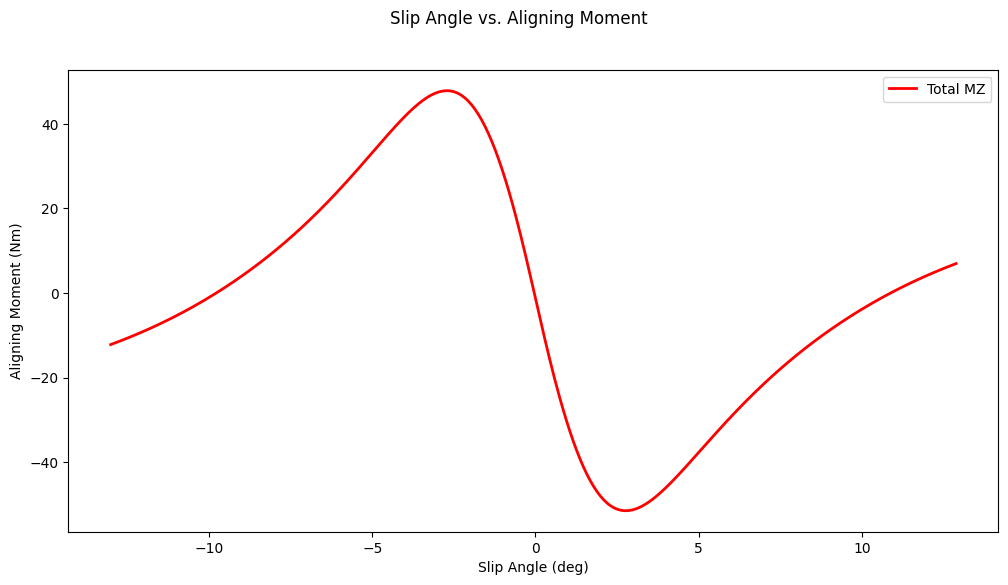

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

# Define the simplified Pacejka model function
def pacejka_model(alpha, B, C, D, E, F):
    return D * np.sin(C * np.arctan(B * alpha - E * (B * alpha - np.arctan(B * alpha))) + F)

# Assuming data is loaded and prepared
data_path = 'B1320run52.csv'
data = pd.read_csv(data_path)
data['FY'] = pd.to_numeric(data['FY'], errors='coerce') * -1
data['SA'] = pd.to_numeric(data['SA'], errors='coerce')
data['FZ'] = pd.to_numeric(data['FZ'], errors='coerce')
data['IA'] = pd.to_numeric(data['IA'], errors='coerce')
data['V'] = pd.to_numeric(data['V'], errors='coerce')
data['MZ'] = pd.to_numeric(data['MZ'], errors='coerce') * -1  # Ensure MZ is negative if flipping
data.dropna(subset=['FY', 'SA', 'FZ', 'IA', 'V', 'MZ'], inplace=True)

# Define bins with specific ranges and prepare model parameters
bins = [
    {'fz_range': (-1200, -1000), 'ia_range': (0.9, 1.1), 'v_range': (0, 42)},
    {'fz_range': (-300, -100), 'ia_range': (2.9, 3.1), 'v_range': (0, 42)}
]
model_params_mz = []
x_model = np.linspace(min(data['SA']), max(data['SA']), 500)
z_total_model = np.zeros_like(x_model)

# Fit model for MZ
for bin_info in bins:
    filtered_data = data[
        (data['FZ'] >= bin_info['fz_range'][0]) & (data['FZ'] <= bin_info['fz_range'][1]) &
        (data['IA'] >= bin_info['ia_range'][0]) & (data['IA'] <= bin_info['ia_range'][1]) &
        (data['V'] >= bin_info['v_range'][0]) & (data['V'] <= bin_info['v_range'][1])
        ]
    x_data = filtered_data['SA']
    mz_data = filtered_data['MZ']

    if not x_data.empty and not mz_data.empty:
        initial_guess = [1.1, 1.1, max(mz_data), 1, 1]  # Updated initial guess
        popt_mz, _ = curve_fit(pacejka_model, x_data, mz_data, p0=initial_guess, maxfev=15000)
        model_params_mz.append(popt_mz)
        z_total_model += pacejka_model(x_model, *popt_mz)

# Plotting the MZ data
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(x_model, z_total_model, 'r', label='Total MZ', linewidth=2)
ax.set_xlabel('Slip Angle (deg)')
ax.set_ylabel('Aligning Moment (Nm)', color='black')
ax.tick_params(axis='y', labelcolor='black')
fig.suptitle('Slip Angle vs. Aligning Moment')
ax.legend(loc='upper right')
plt.show()
